In [1]:
import sys
import pandas as pd
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools
sys.path.append("C:/dev/pyktrader3/")
from pycmqlib3.utility import misc
from bktest import backtest
import pycmqlib3.analytics.data_handler as dh

In [2]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'ZC', 'SM', "SF"]
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg']
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP'] #, 'sp', 'CJ', 'UR']
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts


In [3]:
field_list = ['open', 'high', 'low', 'close', 'volume', 'openInterest', 'contract', 'shift']
factor_list = ['lr_std','up_std','lr_skew','lr_kurt','min_cnt','vol_mf','oi_mf','trd_str','vol_mfratio']
start_date = datetime.date(2015,1,1)
end_date = datetime.date(2021,4,7)
pnl_tenors = ['1y', '2y', '3y', '4y', '5y', '6y']

sim_products = ind_all_mkts + ags_all_mkts
need_shift = 1
freq = 's1'

delimiter = '-'
df_list = []
atr_win = 20
file_folder = "C:\\dev\\data\\data_cache\\"

for idx, asset in enumerate(sim_products):
    for idy, nb in enumerate([1, 2]):
        filename = "%s_%s_%s_%s.csv" % (asset, nb, freq, end_date.strftime("%Y%m%d"))
        df = pd.read_csv(file_folder + filename, index_col=0)
        df = df.drop_duplicates(subset=['date', 'split_idx'], keep='last').set_index(['date', 'split_idx'])
        df = df.drop(['cum_idx'], axis=1)
        ep_field = [ col for col in df.columns if 'exec_price' in col]
        xdf = df[field_list + ep_field + factor_list]
        #xdf['expiry'] = xdf['contract'].apply(lambda x: misc.contract_expiry(x, misc.CHN_Holidays))
        xdf['contmth'] = xdf['contract'].apply(lambda x: misc.inst2contmth(x))
        xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100)        
        xdf.columns = [delimiter.join((asset+str(nb), col)) for col in xdf.columns]
        df_list.append(xdf)

df = pd.concat(df_list, axis = 1, sort = False).sort_index()
print(df.tail(20))


<ipython-input-3-0303f7ad4138>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xdf['contmth'] = xdf['contract'].apply(lambda x: misc.inst2contmth(x))
<ipython-input-3-0303f7ad4138>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100)


                               rb1-open  rb1-high  rb1-low  rb1-close  \
date                split_idx                                           
2021-03-10 00:00:00 0            4538.0    4574.0   4492.0     4496.0   
2021-03-11 00:00:00 0            4493.0    4738.0   4442.0     4738.0   
2021-03-12 00:00:00 0            4748.0    4764.0   4608.0     4647.0   
2021-03-15 00:00:00 0            4653.0    4728.0   4637.0     4700.0   
2021-03-16 00:00:00 0            4708.0    4736.0   4597.0     4692.0   
2021-03-17 00:00:00 0            4694.0    4756.0   4643.0     4743.0   
2021-03-18 00:00:00 0            4746.0    4759.0   4667.0     4702.0   
2021-03-19 00:00:00 0            4688.0    4816.0   4661.0     4798.0   
2021-03-22 00:00:00 0            4837.0    4837.0   4652.0     4654.0   
2021-03-23 00:00:00 0            4652.0    4681.0   4582.0     4623.0   
2021-03-24 00:00:00 0            4611.0    4764.0   4595.0     4745.0   
2021-03-25 00:00:00 0            4745.0    4780.0  

In [4]:
def run_ts_test(input_args):
    product_list = input_args['product_list']
    mod_prod_list = [asset + str(1) for asset in product_list]
    win = input_args['win']
    ma_win = input_args['ma_win']
    vol_win = input_args['std_win']
    pos_std = input_args['pos_std']
    rebal_freq = input_args['rebal_freq']
    cost_ratio = input_args.get('cost_ratio', 0.5)
    run_mode = input_args.get('run_mode', "ryield")
    params = input_args.get('params', [0.0, 0.0])
    prefix = input_args.get('prefix', "")
    run_name = input_args.get('run_name', 'test')
    resp_func = input_args.get('rsp_func', 'sign')
    start_date = input_args.get('start_date', None)
    end_date = input_args.get('end_date', None)
    select_cols = []
    data_field = ''
    for col in df.columns:
        col_split = col.split(delimiter)
        if col_split[0][:-1] in product_list:
            select_cols.append(col)
    xdf= df[select_cols].sort_index().copy()
    if start_date:
        xdf = xdf[xdf.index>= start_date]
    if end_date:
        xdf = xdf[xdf.index<= end_date]
    for asset in product_list:
        if need_shift == 1:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))] - xdf[delimiter.join((asset + str(1), 'shift'))]) \
                    - np.log(xdf[delimiter.join((asset + str(2), 'close'))]- xdf[delimiter.join((asset + str(2), 'shift'))]))\
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = xdf[delimiter.join((asset+ str(1), 'close'))]-xdf[delimiter.join((asset+ str(1), 'shift'))]
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))]-xdf[delimiter.join((asset + str(i), 'shift'))]) \
                    - np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1)-xdf[delimiter.join((asset + str(i), 'shift'))])
        elif need_shift == 2:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) - np.log(xdf[delimiter.join((asset + str(2), 'close'))])\
                     - xdf[delimiter.join((asset + str(1), 'shift'))] + xdf[delimiter.join((asset + str(2), 'shift'))]) \
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = xdf[delimiter.join((asset+ str(1), 'close'))]* np.exp(-xdf[delimiter.join((asset+ str(1), 'shift'))])
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))])- np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1))
        else:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) - np.log(xdf[delimiter.join((asset + str(2), 'close'))])) \
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = df[delimiter.join((asset+ str(1), 'close'))]
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))])- np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1))
        xdf[delimiter.join((asset + str(1), 'basmom'))] = xdf[delimiter.join((asset + str(1), 'lr'))].rolling(win).sum() \
                                                        - xdf[delimiter.join((asset + str(2), 'lr'))].rolling(win).sum()
        
        if 'ma' == run_mode[-2:]:
            xdf[delimiter.join((asset + str(1), run_mode))] = xdf[delimiter.join((asset + str(1), run_mode[:-2]))].rolling(ma_win).mean()
        data_field = run_mode
        if pos_std == 0:
            xdf[delimiter.join((asset + str(1), 'std'))] = orig_close
        elif pos_std == 1:
            if need_shift == 1:
                xdf[delimiter.join((asset + str(1), 'std'))] = dh.ATR(xdf, vol_win, prefix = asset + '1' + delimiter).fillna(method='bfill') * 10.0
            elif need_shift == 2:
                xdf[delimiter.join((asset + str(1), 'std'))] = (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) \
                                - np.log(xdf[delimiter.join((asset + str(1), 'close'))].shift(1))).rolling(vol_win).std() \
                                * orig_close * 10
            else:
                xdf[delimiter.join((asset + str(1), 'std'))] = orig_close
        if 'ma' == run_mode[-2:]:
            xdf[delimiter.join((asset + str(1), 'signal_r'))] = xdf[delimiter.join((asset + str(1), data_field))] \
                                                            - xdf[delimiter.join((asset + str(1), data_field[:-2]))]
        else:
            xdf[delimiter.join((asset + str(1), 'signal_r'))] = xdf[delimiter.join((asset + str(1), data_field))] - params[0]
        

    select_cols = []
    for col in xdf.columns:
        col_split = col.split(delimiter)
        if (col_split[0] in mod_prod_list):
            select_cols.append(col)    
    
    adf = xdf[select_cols].copy()
    fdf = adf[[delimiter.join((asset, data_field)) for asset in mod_prod_list]]
    adf['prod_count'] = fdf.apply(lambda x: x.count() if x.count() > 0 else np.nan, axis=1)
    adf['rebal_seqno'] = range(len(adf.index))
    
    total_risk = 5000000.0
    margin_rate = [0.08, 0.08]
    offset_list = [ backtest.trade_offset_dict.get(asset, 0.0) for asset in product_list]
    offset_list = [ offset * cost_ratio for offset in offset_list]
    start_capital = 0.0

    long_pos = pd.DataFrame(0, columns = mod_prod_list, index = adf.index)
    short_pos = pd.DataFrame(0, columns = mod_prod_list, index = adf.index)

    for rebal_idx in range(rebal_freq):
        long_tmp = pd.DataFrame(columns=mod_prod_list, index = adf.index)
        short_tmp = pd.DataFrame(columns=mod_prod_list, index = adf.index)
        rebal_flag = adf['rebal_seqno'].apply(lambda x: (x % rebal_freq) == rebal_idx)
        for asset in mod_prod_list:
            if run_mode[-2:] == 'ma':
                long_tmp.loc[(adf[delimiter.join((asset, data_field))] <  adf[delimiter.join((asset, data_field[:-2]))]) & rebal_flag, asset] = 1.0
                long_tmp.loc[(adf[delimiter.join((asset, data_field))] >= adf[delimiter.join((asset, data_field[:-2]))]) & rebal_flag, asset] = 0.0
                short_tmp.loc[(adf[delimiter.join((asset, data_field))]>  adf[delimiter.join((asset, data_field[:-2]))]) & rebal_flag, asset] = 1.0
                short_tmp.loc[(adf[delimiter.join((asset, data_field))]<= adf[delimiter.join((asset, data_field[:-2]))]) & rebal_flag, asset] = 0.0                
            else:
                long_tmp.loc[(adf[delimiter.join((asset, data_field))]>  params[1]) & rebal_flag, asset] = 1.0
                long_tmp.loc[(adf[delimiter.join((asset, data_field))]<= -params[1]) & rebal_flag, asset] = 0.0
                short_tmp.loc[(adf[delimiter.join((asset, data_field))]< -params[1]) & rebal_flag, asset] = 1.0
                short_tmp.loc[(adf[delimiter.join((asset, data_field))]>= params[1]) & rebal_flag, asset] = 0.0
        long_tmp = long_tmp.fillna(method='ffill').fillna(0)
        short_tmp = short_tmp.fillna(method='ffill').fillna(0)
        long_pos = long_pos + long_tmp
        short_pos = short_pos + short_tmp
    
    extract_fields = ['open', 'close', 'traded_price', 'contract', 'cost', 'pos']
    df_list = []

    for asset, offset in zip(mod_prod_list, offset_list):
        long_pos[asset] = (long_pos[asset] * total_risk / rebal_freq \
                    /(adf['prod_count'] * adf[delimiter.join((asset,'std'))])).shift(1).fillna(method='ffill') 
        short_pos[asset] = (short_pos[asset] * total_risk / rebal_freq \
                    /(adf['prod_count'] *adf[delimiter.join((asset,'std'))])).shift(1).fillna(method='ffill')
        adf[delimiter.join((asset, 'pos'))] = long_pos[asset].fillna(0.0) - short_pos[asset].fillna(0.0)
        adf[delimiter.join((asset, 'traded_price'))] = adf[delimiter.join((asset, 'open'))]
        adf[delimiter.join((asset, 'pos'))].iloc[-1] = 0
        adf[delimiter.join((asset, 'cost'))] = \
                abs(adf[delimiter.join((asset, 'pos'))] \
                - adf[delimiter.join((asset, 'pos'))].shift(1)) * offset
        adf[delimiter.join((asset, 'cost'))] = adf[delimiter.join((asset, 'cost'))].fillna(0.0)
        fields = [delimiter.join((asset, field)) for field in extract_fields] 
        tdf = adf[fields]
        tdf.columns = extract_fields
        tdf.index.name = 'date'    
        if freq == 'm':
            tdf['date'] = adf['date']
            tdf['min_id'] = adf['min_id']
        #closed_trades = backtest.simdf_to_trades1(tdf, slippage = offset)
        df_list.append(tdf)
    (res_pnl, ts) = backtest.get_pnl_stats(df_list, margin_rate, freq, tenors = pnl_tenors, start_capital = start_capital, cost_ratio = cost_ratio)
    pos_df  = adf[[delimiter.join((asset, 'pos')) for asset in mod_prod_list]]
    pos_df.columns  = [delimiter.join((asset, 'pos')) for asset in product_list]
    cum_pnl = ts['cum_pnl']
    cum_pnl.name = run_name
    pnl_df = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
    pnl_df.columns = [run_name]
    res = {'cum_pnl': ts['cum_pnl'], 'name': run_name, 'pnl_stats': pnl_df, 'pos_df': pos_df}
    return res


In [5]:
def run_xs_test(input_args):
    product_list = input_args['product_list']
    mod_prod_list = [asset + str(1) for asset in product_list]
    mom_win = input_args['win']
    ma_win = input_args['ma_win']
    vol_win = input_args['std_win']
    pos_std = input_args['pos_std']
    rebal_freq = input_args['rebal_freq']
    cost_ratio = input_args.get('cost_ratio', 0.5)
    quantile_cutoff = input_args['quantile']
    run_mode = input_args.get('run_mode', "momma")
    params = input_args.get('params', [0.0])
    prefix = input_args.get('prefix', "")
    run_name = input_args.get('run_name', 'test')
    start_date = input_args.get('start_date', None)
    end_date = input_args.get('end_date', None)
    select_cols = []
    rank_field = ''
    for col in df.columns:
        col_split = col.split(delimiter)
        if col_split[0][:-1] in product_list:
            select_cols.append(col)
    xdf= df[select_cols].sort_index().copy()
    if start_date:
        xdf = xdf[xdf.index>= start_date]
    if end_date:
        xdf = xdf[xdf.index<= end_date]

    for asset in product_list:
        if need_shift == 1:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))] - xdf[delimiter.join((asset + str(1), 'shift'))]) \
                    - np.log(xdf[delimiter.join((asset + str(2), 'close'))]- xdf[delimiter.join((asset + str(2), 'shift'))]))\
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = xdf[delimiter.join((asset+ str(1), 'close'))]-xdf[delimiter.join((asset+ str(1), 'shift'))]
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))]-xdf[delimiter.join((asset + str(i), 'shift'))]) \
                    - np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1)-xdf[delimiter.join((asset + str(i), 'shift'))])
        elif need_shift == 2:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) - np.log(xdf[delimiter.join((asset + str(2), 'close'))])\
                     - xdf[delimiter.join((asset + str(1), 'shift'))] + xdf[delimiter.join((asset + str(2), 'shift'))]) \
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = xdf[delimiter.join((asset+ str(1), 'close'))]* np.exp(-xdf[delimiter.join((asset+ str(1), 'shift'))])
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))])- np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1))
        else:
            xdf[delimiter.join((asset + str(1), 'ryield'))] = \
                    (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) - np.log(xdf[delimiter.join((asset + str(2), 'close'))])) \
                    /(xdf[delimiter.join((asset + str(2), 'mth'))] - xdf[delimiter.join((asset + str(1), 'mth'))]) * 12.0
            orig_close = df[delimiter.join((asset+ str(1), 'close'))]
            for i in [1, 2]:
                xdf[delimiter.join((asset + str(i), 'lr'))] = \
                    np.log(xdf[delimiter.join((asset + str(i), 'close'))])- np.log(xdf[delimiter.join((asset + str(i), 'close'))].shift(1))
        xdf[delimiter.join((asset + str(1), 'basmom'))] = xdf[delimiter.join((asset + str(1), 'lr'))].rolling(win).sum() \
                                                        - xdf[delimiter.join((asset + str(2), 'lr'))].rolling(win).sum()
        if run_mode in ['ryield', 'basmom']:
            rank_field = run_mode
        elif run_mode == 'ryieldma':
            xdf[delimiter.join((asset + str(1), 'ryieldma'))] = xdf[delimiter.join((asset + str(1), 'ryield'))].rolling(ma_win).mean()
            rank_field = 'ryieldma'
        elif run_mode == 'basmomma':
            xdf[delimiter.join((asset + str(1), 'basmomma'))] = xdf[delimiter.join((asset + str(1), 'basmom'))].rolling(ma_win).mean()
            rank_field = 'basmomma'
        if pos_std == 0:
            xdf[delimiter.join((asset + str(1), 'std'))] = orig_close
        elif pos_std == 1:
            if need_shift == 1:
                xdf[delimiter.join((asset + str(1), 'std'))] = dh.ATR(xdf, vol_win, prefix = asset + '1' + delimiter).fillna(method='bfill') * 10.0
            elif need_shift == 2:
                xdf[delimiter.join((asset + str(1), 'std'))] = (np.log(xdf[delimiter.join((asset + str(1), 'close'))]) \
                                - np.log(xdf[delimiter.join((asset + str(1), 'close'))].shift(1))).rolling(vol_win).std() \
                                * orig_close * 10
            else:
                xdf[delimiter.join((asset + str(1), 'std'))] = orig_close

    select_cols = []
    for col in xdf.columns:
        col_split = col.split(delimiter)
        if (col_split[0] in mod_prod_list):
            select_cols.append(col)    
    
    total_risk = 5000000.0
    margin_rate = [0.08, 0.08]
    offset_list = [ backtest.trade_offset_dict.get(asset, 0.0) for asset in product_list]
    offset_list = [ offset * cost_ratio for offset in offset_list]
    start_capital = 0.0
    
    adf = xdf[select_cols].copy()
    rank_df = adf[[delimiter.join((asset, rank_field)) for asset in mod_prod_list]].rank(axis=1)
    rank_df.columns = mod_prod_list
    
    adf['prod_count'] = rank_df.apply(lambda x: x.count() if x.count() > 0 else np.nan, axis=1).fillna(0)
    adf['kcut'] = (adf['prod_count'] * quantile_cutoff).astype('int')
    adf['upper_rank'] = adf['prod_count'] - adf['kcut']
    adf['lower_rank'] = adf['kcut'] + 1 
    adf['rebal_seqno'] = range(len(adf.index))

    long_pos = pd.DataFrame(0, columns = mod_prod_list, index = adf.index)
    short_pos = pd.DataFrame(0, columns = mod_prod_list, index = adf.index)

    for rebal_idx in range(rebal_freq):
        long_tmp = pd.DataFrame(columns=mod_prod_list, index = adf.index)
        short_tmp = pd.DataFrame(columns=mod_prod_list, index = adf.index)
        rebal_flag = adf['rebal_seqno'].apply(lambda x: (x % rebal_freq) == rebal_idx)
        for asset in mod_prod_list:
            long_tmp.loc[(rank_df[asset]>adf['upper_rank']) & rebal_flag, asset] = 1.0
            long_tmp.loc[(rank_df[asset]<=adf['upper_rank']) & rebal_flag, asset] = 0.0
            short_tmp.loc[(rank_df[asset]<adf['lower_rank']) & rebal_flag, asset] = 1.0
            short_tmp.loc[(rank_df[asset]>=adf['lower_rank']) & rebal_flag, asset] = 0.0
        long_tmp = long_tmp.fillna(method='ffill').fillna(0)
        short_tmp = short_tmp.fillna(method='ffill').fillna(0)
        long_sum = long_tmp.sum(axis=1)
        short_sum = short_tmp.sum(axis=1)
        long_pos = long_pos + long_tmp.div(long_sum,axis=0)
        short_pos = short_pos + short_tmp.div(short_sum,axis=0)

    extract_fields = ['open', 'close', 'traded_price', 'contract', 'cost', 'pos']
    df_list = []

    for asset, offset in zip(mod_prod_list, offset_list):
        long_pos[asset] = (long_pos[asset] * total_risk / rebal_freq \
                    /(adf[delimiter.join((asset,'std'))])).shift(1).fillna(method='ffill') 
        short_pos[asset] = (short_pos[asset] * total_risk / rebal_freq \
                    /(adf[delimiter.join((asset,'std'))])).shift(1).fillna(method='ffill')
        adf[delimiter.join((asset, 'pos'))] = long_pos[asset].fillna(0.0) - short_pos[asset].fillna(0.0)
        adf[delimiter.join((asset, 'traded_price'))] = adf[delimiter.join((asset, 'open'))]
        adf[delimiter.join((asset, 'pos'))].iloc[-1] = 0
        adf[delimiter.join((asset, 'cost'))] = \
                abs(adf[delimiter.join((asset, 'pos'))] \
                - adf[delimiter.join((asset, 'pos'))].shift(1)) * offset
        adf[delimiter.join((asset, 'cost'))] = adf[delimiter.join((asset, 'cost'))].fillna(0.0)
        fields = [delimiter.join((asset, field)) for field in extract_fields] 
        tdf = adf[fields]
        tdf.columns = extract_fields
        tdf.index.name = 'date'    
        if freq == 'm':
            tdf['date'] = adf['date']
            tdf['min_id'] = adf['min_id']
        #closed_trades = backtest.simdf_to_trades1(tdf, slippage = offset)
        df_list.append(tdf)
    (res_pnl, ts) = backtest.get_pnl_stats(df_list, margin_rate, freq, tenors = pnl_tenors, start_capital = start_capital, cost_ratio = cost_ratio)
    pos_df  = adf[[delimiter.join((asset, 'pos')) for asset in mod_prod_list]]
    pos_df.columns  = [delimiter.join((asset, 'pos')) for asset in product_list]
    cum_pnl = ts['cum_pnl']
    cum_pnl.name = run_name
    pnl_df = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
    pnl_df.columns = [run_name]
    res = {'cum_pnl': ts['cum_pnl'], 'name': run_name, 'pnl_stats': pnl_df, 'pos_df': pos_df}
    return res

<ipython-input-6-cfd9f6c5851a>:77: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  port_pnl = pd.Series()
C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


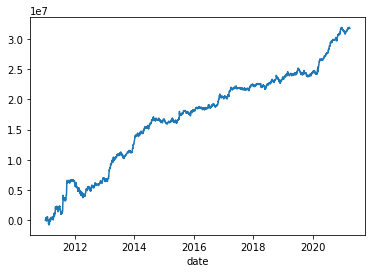

                 tscarry-ryield-commod_mkts-1-1-1-0.2
sharp_ratio_10y                              1.690455
sharp_ratio_1y                               3.617160
sharp_ratio_2y                               2.330763
sharp_ratio_3y                               1.912895
sharp_ratio_4y                               1.646359
sharp_ratio_5y                               1.720310
sharp_ratio_6y                               1.601904
sharp_ratio_8y                               1.734074
std_pnl_10y                             121126.106478
std_pnl_1y                               90244.309884
std_pnl_2y                              105665.374228
std_pnl_3y                              104353.058739
std_pnl_4y                               97778.528167
std_pnl_5y                               99314.166115
std_pnl_6y                              102752.164506
std_pnl_8y                              104019.061846


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


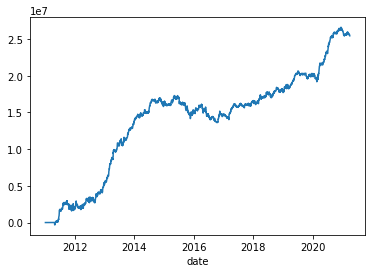

                 tscarry-basmom-commod_mkts-70-1-1-0.2
sharp_ratio_10y                               1.469886
sharp_ratio_1y                                2.587465
sharp_ratio_2y                                2.226749
sharp_ratio_3y                                1.724559
sharp_ratio_4y                                1.685634
sharp_ratio_5y                                1.242266
sharp_ratio_6y                                0.928746
sharp_ratio_8y                                1.271982
std_pnl_10y                              113008.880263
std_pnl_1y                                93397.489853
std_pnl_2y                               100658.418313
std_pnl_3y                               101618.035992
std_pnl_4y                                97573.734941
std_pnl_5y                                99324.311807
std_pnl_6y                               105258.520065
std_pnl_8y                               106840.052011


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


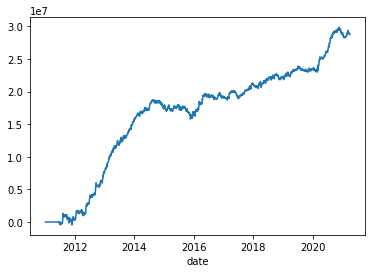

                 tscarry-basmom-commod_mkts-110-1-1-0.2
sharp_ratio_10y                                1.626744
sharp_ratio_1y                                 2.390820
sharp_ratio_2y                                 2.009465
sharp_ratio_3y                                 1.538438
sharp_ratio_4y                                 1.470291
sharp_ratio_5y                                 1.403719
sharp_ratio_6y                                 1.189473
sharp_ratio_8y                                 1.360757
std_pnl_10y                               115363.423998
std_pnl_1y                                 94393.551980
std_pnl_2y                                103403.582293
std_pnl_3y                                102819.012042
std_pnl_4y                                 98106.550540
std_pnl_5y                                 99071.424555
std_pnl_6y                                105379.492747
std_pnl_8y                                107866.745617


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


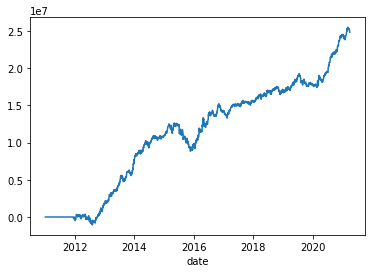

                 tscarry-basmom-commod_mkts-230-1-1-0.2
sharp_ratio_10y                                1.453504
sharp_ratio_1y                                 3.986530
sharp_ratio_2y                                 2.322788
sharp_ratio_3y                                 1.694091
sharp_ratio_4y                                 1.632786
sharp_ratio_5y                                 1.640934
sharp_ratio_6y                                 1.189809
sharp_ratio_8y                                 1.531702
std_pnl_10y                               111570.136487
std_pnl_1y                                 99136.882502
std_pnl_2y                                107862.751045
std_pnl_3y                                106520.593411
std_pnl_4y                                101198.792671
std_pnl_5y                                106272.474563
std_pnl_6y                                118138.683435
std_pnl_8y                                115612.536640


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


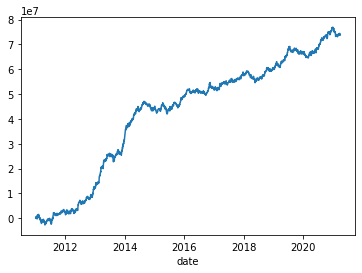

                 xscarry-ryieldma-commod_mkts-1-1-1-0.2
sharp_ratio_10y                                1.643381
sharp_ratio_1y                                 1.540137
sharp_ratio_2y                                 1.385435
sharp_ratio_3y                                 1.280914
sharp_ratio_4y                                 1.214576
sharp_ratio_5y                                 1.102584
sharp_ratio_6y                                 1.105557
sharp_ratio_8y                                 1.466553
std_pnl_10y                               297421.214468
std_pnl_1y                                288835.732071
std_pnl_2y                                284286.742335
std_pnl_3y                                276291.665299
std_pnl_4y                                267497.491230
std_pnl_5y                                274364.271917
std_pnl_6y                                279416.134524
std_pnl_8y                                296622.818300


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


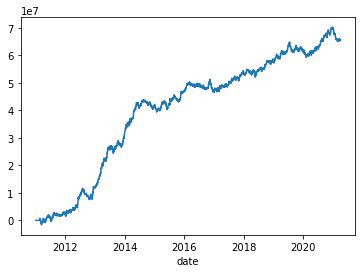

                 xscarry-ryieldma-commod_mkts-1-30-1-0.2
sharp_ratio_10y                                 1.413124
sharp_ratio_1y                                  0.819087
sharp_ratio_2y                                  0.596763
sharp_ratio_3y                                  0.842479
sharp_ratio_4y                                  0.971146
sharp_ratio_5y                                  0.721397
sharp_ratio_6y                                  0.861587
sharp_ratio_8y                                  1.216934
std_pnl_10y                                302291.220281
std_pnl_1y                                 295026.182749
std_pnl_2y                                 289110.212904
std_pnl_3y                                 288659.414337
std_pnl_4y                                 278404.829145
std_pnl_5y                                 286669.822628
std_pnl_6y                                 292749.857895
std_pnl_8y                                 304134.432701


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


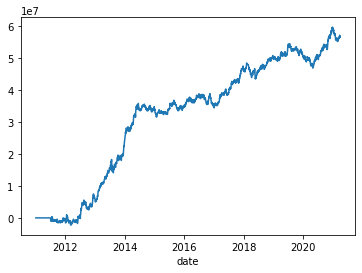

                 xscarry-ryieldma-commod_mkts-1-120-1-0.2
sharp_ratio_10y                                  1.231154
sharp_ratio_1y                                   1.717641
sharp_ratio_2y                                   0.625784
sharp_ratio_3y                                   0.841308
sharp_ratio_4y                                   1.018106
sharp_ratio_5y                                   0.901959
sharp_ratio_6y                                   0.877863
sharp_ratio_8y                                   1.210770
std_pnl_10y                                 300223.680653
std_pnl_1y                                  307024.966544
std_pnl_2y                                  297974.423285
std_pnl_3y                                  294611.395421
std_pnl_4y                                  287477.206795
std_pnl_5y                                  291549.681918
std_pnl_6y                                  290443.638973
std_pnl_8y                                  308341.042708


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


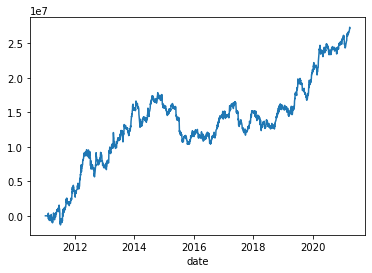

                 xscarry-basmom-commod_mkts-10-1-10-0.2
sharp_ratio_10y                                0.854133
sharp_ratio_1y                                 0.881889
sharp_ratio_2y                                 1.971004
sharp_ratio_3y                                 1.444364
sharp_ratio_4y                                 0.919890
sharp_ratio_5y                                 1.037494
sharp_ratio_6y                                 0.626746
sharp_ratio_8y                                 0.688941
std_pnl_10y                               214020.254418
std_pnl_1y                                185011.666198
std_pnl_2y                                198721.727649
std_pnl_3y                                200676.991351
std_pnl_4y                                198030.340664
std_pnl_5y                                198552.080122
std_pnl_6y                                195503.280948
std_pnl_8y                                202986.415633


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


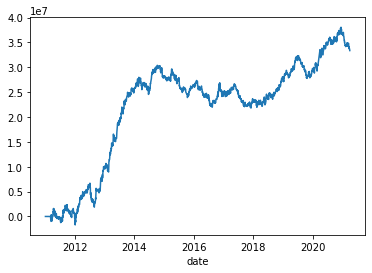

                 xscarry-basmom-commod_mkts-30-1-10-0.2
sharp_ratio_10y                                0.865880
sharp_ratio_1y                                -0.049952
sharp_ratio_2y                                 0.643933
sharp_ratio_3y                                 0.934362
sharp_ratio_4y                                 0.578568
sharp_ratio_5y                                 0.426749
sharp_ratio_6y                                 0.234951
sharp_ratio_8y                                 0.647476
std_pnl_10y                               251567.643859
std_pnl_1y                                245326.997929
std_pnl_2y                                238149.844515
std_pnl_3y                                233638.389312
std_pnl_4y                                223034.058737
std_pnl_5y                                230744.127270
std_pnl_6y                                228627.134584
std_pnl_8y                                238679.200937


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


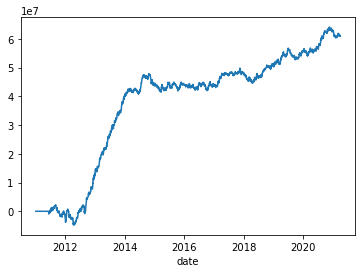

                 xscarry-basmom-commod_mkts-100-1-1-0.2
sharp_ratio_10y                                1.371910
sharp_ratio_1y                                 1.031445
sharp_ratio_2y                                 1.106779
sharp_ratio_3y                                 1.248335
sharp_ratio_4y                                 0.900939
sharp_ratio_5y                                 0.906177
sharp_ratio_6y                                 0.757753
sharp_ratio_8y                                 1.209430
std_pnl_10y                               290270.493050
std_pnl_1y                                264144.118997
std_pnl_2y                                257099.942912
std_pnl_3y                                262064.624610
std_pnl_4y                                252592.037870
std_pnl_5y                                255827.858187
std_pnl_6y                                259737.700821
std_pnl_8y                                274497.791568


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


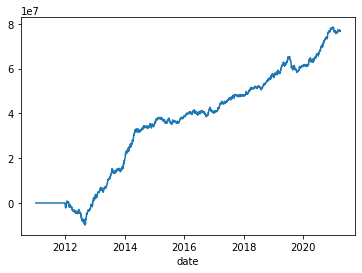

                 xscarry-basmom-commod_mkts-240-1-1-0.2
sharp_ratio_10y                                1.686512
sharp_ratio_1y                                 2.712008
sharp_ratio_2y                                 1.903357
sharp_ratio_3y                                 1.877555
sharp_ratio_4y                                 1.856229
sharp_ratio_5y                                 1.705160
sharp_ratio_6y                                 1.514498
sharp_ratio_8y                                 1.991228
std_pnl_10y                               296805.327581
std_pnl_1y                                286401.134763
std_pnl_2y                                302326.021142
std_pnl_3y                                289513.490186
std_pnl_4y                                278950.989908
std_pnl_5y                                282578.969208
std_pnl_6y                                275961.920387
std_pnl_8y                                290448.335720


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


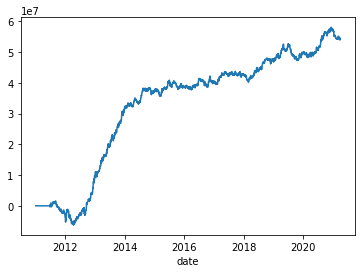

                 xscarry-basmomma-commod_mkts-100-10-5-0.2
sharp_ratio_10y                                   1.237831
sharp_ratio_1y                                    0.995160
sharp_ratio_2y                                    0.589992
sharp_ratio_3y                                    0.955133
sharp_ratio_4y                                    0.744777
sharp_ratio_5y                                    0.806999
sharp_ratio_6y                                    0.724550
sharp_ratio_8y                                    1.159840
std_pnl_10y                                  285403.125908
std_pnl_1y                                   273173.307480
std_pnl_2y                                   271471.350430
std_pnl_3y                                   270159.170818
std_pnl_4y                                   257315.703449
std_pnl_5y                                   263150.977622
std_pnl_6y                                   261428.916862
std_pnl_8y                                   272663.2243

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


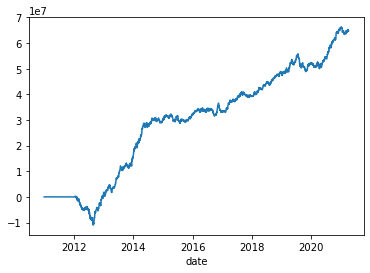

                 xscarry-basmomma-commod_mkts-240-10-5-0.2
sharp_ratio_10y                                   1.440453
sharp_ratio_1y                                    2.860972
sharp_ratio_2y                                    1.555293
sharp_ratio_3y                                    1.671361
sharp_ratio_4y                                    1.616837
sharp_ratio_5y                                    1.453980
sharp_ratio_6y                                    1.314552
sharp_ratio_8y                                    1.715202
std_pnl_10y                                  293404.617484
std_pnl_1y                                   293717.557504
std_pnl_2y                                   308423.796190
std_pnl_3y                                   288557.797736
std_pnl_4y                                   278549.202586
std_pnl_5y                                   282819.140291
std_pnl_6y                                   275097.852375
std_pnl_8y                                   291182.0356

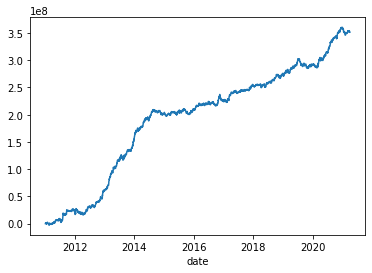

date
2021-02-19    3.497061e+08
2021-02-22    3.500090e+08
2021-02-23    3.501914e+08
2021-02-24    3.491302e+08
2021-02-25    3.497224e+08
2021-02-26    3.499439e+08
2021-03-01    3.504499e+08
2021-03-02    3.512043e+08
2021-03-03    3.520343e+08
2021-03-04    3.517787e+08
2021-03-05    3.527220e+08
2021-03-08    3.522113e+08
2021-03-09    3.541985e+08
2021-03-10    3.526940e+08
2021-03-11    3.529769e+08
2021-03-12    3.529406e+08
2021-03-15    3.532426e+08
2021-03-16    3.539845e+08
2021-03-17    3.534044e+08
2021-03-18    3.532268e+08
2021-03-19    3.526782e+08
2021-03-22    3.530333e+08
2021-03-23    3.526477e+08
2021-03-24    3.537690e+08
2021-03-25    3.540484e+08
2021-03-26    3.542600e+08
2021-03-29    3.519760e+08
2021-03-30    3.523466e+08
2021-03-31    3.515525e+08
2021-04-01    3.515087e+08
Name: daily_pnl, dtype: float64
                            0
sharp_ratio_10y  2.120193e+00
sharp_ratio_1y   2.850383e+00
sharp_ratio_2y   2.105567e+00
sharp_ratio_3y   1.878064e+00
sha

In [6]:
res = {}
stats_list = []
cum_list = []
sratio_years = [int(ten[:-1]) for ten in pnl_tenors]

metal_mixed_mkts = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'ZC', 'cu', 'al', 'zn', 'ni']
petro_mixed_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc']
ags_mixed_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'CF', 'SR', 'jd']
commod_mkts = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'ZC', 'cu', 'al', 'zn', 'pb', 'ni', 'sn', \
               'l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'CF', 'SR', 'jd'] 
# 'SM', "SF", 'au', 'ag', 'fu', 'eg', 'b', 'AP']

product_list = commod_mkts # metal_mixed_mkts + petro_mixed_mkts #  
# # ind_metal_mkts #commod_all_mkts #  ferrous_products_mkts #+ ferrous_mixed_mkts + base_metal_mkts
product_name = 'commod_mkts'

sim_name = 'tscarry'
run_mode = 'nryield'

start_date = datetime.date(2011,1,1)
end_date = datetime.date(2021,4,1)
quant = 0.2
#save_loc = "C:\\dev\\data\\selected_%s_" % ('_'.join([sim_name, run_mode, product_name, str(quant), str(end_date)]))
save_loc = "C:\\dev\\data\\combined_carry_" + product_name + "_" + str(end_date) + '_'
pos_std = 1
std_win = 20
win = 60
ma_win = 1
rebal = 5
params = [0.0, 0.0]

#index_list = range(10, 250, 10) # [1, 5] + [i for i in range(10, 130, 10)]  #range(8, 44, 4) # 
#column_list = [1, 3, 5, 10, 15, 20] #range(10, 130, 10) #  [60, 80, 100, 120, 140, 160] #[i * 0.01 for i in range(0, 32, 4)] #
sratio = {}
run_sratio = False
run_pos_sum = True
pos_sum = pd.DataFrame()
pos_list = []
#scenarios = list(itertools.product(index_list, column_list))
#ind_metal_mkts
#scenarios = [('tscarry', 'ryield', 3.0, 1, 1, 5, [0.0, 0.0]), \
#             ('tscarry', 'basmom', 1.0, 60, 1, 10, [0.0, 0.0]), \
#             ('tscarry', 'basmom', 1.0, 100, 1, 10, [0.0, 0.0]),\
#             ('tscarry', 'basmom', 1.0, 240, 1, 10, [0.0, 0.0]),\
#             ('xscarry', 'ryieldma', 0.0, 1, 1, 5, [0.0, 0.0], 0.25), \
#             ('xscarry', 'ryieldma', 0.0, 1,50, 5, [0.0, 0.0], 0.25), \
#             ('xscarry', 'basmom', 0.0, 110, 1, 5, [0.0, 0.0], 0.25), \
#             ('xscarry', 'basmom', 0.0, 140, 1, 5, [0.0, 0.0], 0.25), 
#             ('xscarry', 'basmomma', 0.0, 90, 20, 5, [0.0, 0.0], 0.25), \
#             ('xscarry', 'basmomma', 0.0, 230, 20, 5, [0.0, 0.0], 0.25), ]
#('xscarry', 'basmom', 170, 1, 5, [0.0, 0.0], 0.25), \
#('xscarry', 'basmom', 210, 1, 5, [0.0, 0.0], 0.25), \
#commod_mkts
scenarios = [('tscarry', 'ryield', 3.0, 1, 1, 1, [0.0, 0.0]), \
             ('tscarry', 'basmom', 1.0, 70, 1, 1, [0.0, 0.0]), \
             ('tscarry', 'basmom', 1.0, 110, 1, 1, [0.0, 0.0]),\
             ('tscarry', 'basmom', 1.0, 230, 1, 1, [0.0, 0.0]),\
             ('xscarry', 'ryieldma', 0.5, 1, 1, 1, [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldma', 0.5, 1, 30, 1, [0.0, 0.0], 0.2), \
             ('xscarry', 'ryieldma', 0.5, 1, 120, 1, [0.0, 0.0], 0.2),\
             ('xscarry', 'basmom', 0.25, 10, 1, 10, [0.0, 0.0], 0.2), \
             ('xscarry', 'basmom', 0.25, 30, 1, 10, [0.0, 0.0], 0.2), \
             ('xscarry', 'basmom', 0.25, 100, 1, 1, [0.0, 0.0], 0.2), \
             ('xscarry', 'basmom', 0.25, 240, 1, 1, [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomma', 0.25, 100, 10, 5, [0.0, 0.0], 0.2), \
             ('xscarry', 'basmomma', 0.25, 240, 10, 5, [0.0, 0.0], 0.2), \
           ]

if 'ts' in sim_name:
    sim_func = run_ts_test
elif 'xs' in sim_name:
    sim_func = run_xs_test
if run_sratio:
    for yr in sratio_years:
        sratio[yr] = pd.DataFrame(0, index = index_list, columns = column_list)

port_pnl = pd.Series()

for scen in scenarios:
    quantile = quant
    if len(scen) == 2:
        scen_x = scen[0]
        scen_y = scen[1]
        if run_mode in ['ryield']:
            win = 1
            ma_win = 1
            rebal = scen_y 
            if sim_name == 'xscarry':
                quantile = scen_x * 0.1
        elif run_mode in ['basmom']:
            win = scen_x
            ma_win = 1
            rebal = scen_y
        elif run_mode in ['basmomma']:
            win = scen_x
            ma_win = scen_y
            rebal = 5
        elif run_mode in ['nyield']:
            win = scen_x
            
        elif run_mode == 'ryieldma':
            rebal = scen_y
            ma_win = scen_x
        else:
            print("unsupported run_mode")
            continue
    elif len(scen) >= 7:
        sim_name = scen[0]
        if 'ts' in sim_name:
            sim_func = run_ts_test
        elif 'xs' in sim_name:
            sim_func = run_xs_test
            if len(scen) == 7:
                quantile = scen[6]
        run_mode = scen[1]
        weight = scen[2]
        win = scen[3]
        ma_win = scen[4]
        rebal = scen[5]
        params = scen[6]
    else:
        print("unsupported scenarios")
        continue
    run_args = {}        
    run_args['run_name'] = run_name = '-'.join([sim_name, run_mode, product_name, str(win), str(ma_win), str(rebal), str(quantile)])
    run_args['cost_ratio'] = 0.5
    run_args['product_list'] = product_list
    run_args['start_date'] = start_date
    run_args['end_date'] = end_date
    
    run_args['win'] = win
    run_args['ma_win'] = ma_win
    run_args['std_win'] = std_win
    run_args['prefix'] = save_loc        
    run_args['rebal_freq'] = rebal
    run_args['pos_std'] = pos_std
    run_args['params'] = params
    run_args['run_mode'] = run_mode
    run_args['quantile'] = quantile 
    res = sim_func(run_args)
    res['cum_pnl'].plot()
    plt.show()
    cum_list.append(res['cum_pnl'])
    stats_list.append(res['pnl_stats'])
    vdf = res['pnl_stats']
    vdf = vdf.loc[[idx for idx in vdf.index if ('sharp' in idx) or ('std' in idx)], :]
    print(vdf)
    if run_pos_sum:
        pos_list.append(res['pos_df'])
        pos_sum = pos_sum.add(res['pos_df'] * weight, fill_value = 0) 
        port_pnl = port_pnl.add(res['cum_pnl'] * weight, fill_value = 0)
    if run_sratio:
        for yr in sratio_years:
            lbl = 'sharp_ratio_' + str(yr) + 'y'
            sratio[yr][scen_y].loc[scen_x] = res['pnl_stats'][run_name][lbl]

port_pnl.plot()
port_pnl.name = 'daily_pnl'
plt.show()
res_pnl = backtest.pnl_stats_by_tenor(port_pnl.diff().dropna(), tenors = pnl_tenors, field = None)
vdf = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
vdf = vdf.loc[[idx for idx in vdf.index if ('sharp' in idx) or ('std' in idx)], :]
print(port_pnl[-30:])
print(vdf)
cum_df = pd.concat(cum_list, axis = 1)
cum_df.to_csv(save_loc + 'pnl.csv')
stats_df = pd.concat(stats_list, axis = 1)
stats_df.T.to_csv(save_loc + 'stats.csv')
if run_pos_sum:
    print(pos_sum)
if run_sratio:
    for yr in sratio_years:
        print(sratio[yr])


In [7]:
save_xl = True
if run_pos_sum and save_xl:
    xlfile = save_loc + "pos_data.xlsx"
    writer = pd.ExcelWriter(xlfile)
    for idx in range(len(pos_list)):            
        pos_list[idx].to_excel(writer, str(idx), startcol= 0, startrow=1)
    pos_sum.to_excel(writer, "sum", startcol= 0, startrow=1)
    writer.save()    
if run_sratio and save_xl:
    xlfile = save_loc + "sratio_heatmap.xlsx"
    writer = pd.ExcelWriter(xlfile)
    for yr in sratio_years:
        lbl = 'sharp_ratio_' + str(yr) + 'y'
        sratio[yr].to_excel(writer, lbl, startcol= 0, startrow=1)
    writer.save()    